In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.random.seed(1)

In [4]:
data = pd.read_csv("data/archive/train.csv")
# data_test = pd.read_csv("data/archive/mnist_test.csv")

In [5]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)
print(m, n)

42000 785


In [7]:
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255

In [8]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Initialize parameters


In [9]:
def init_params():
    W1 = np.random.randn(10, 784) * 0.01
    b1 = np.random.randn(10, 1)
    W2 = np.random.randn(10, 10) * 0.01
    b2 = np.random.randn(10, 1)
    return W1, b1, W2, b2

Forward Propagation

In [10]:
def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / np.sum(expZ, axis=0, keepdims=True)

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

Backwards Propagation

In [11]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max()+1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def deriv_ReLU(Z):
    return Z > 0

def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 -= (alpha * dW1)
    b1 -= alpha * db1
    W2 -= (alpha * dW2)
    b2 -= alpha * db2
    return W1, b1, W2, b2



Using gradient descent

In [25]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            print("Accuracy: ", get_accuracy(get_predictions(A2), Y))
    return W1, b1, W2, b2

In [13]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 350, 0.1)

Iteration:  0
[4 4 4 ... 4 4 4] [5 7 0 ... 2 1 1]
Accuracy:  0.09685365853658537
Iteration:  10
[0 0 0 ... 4 0 4] [5 7 0 ... 2 1 1]
Accuracy:  0.143390243902439
Iteration:  20
[8 3 8 ... 4 3 4] [5 7 0 ... 2 1 1]
Accuracy:  0.1801219512195122
Iteration:  30
[8 3 8 ... 4 3 4] [5 7 0 ... 2 1 1]
Accuracy:  0.21582926829268292
Iteration:  40
[8 3 0 ... 4 3 4] [5 7 0 ... 2 1 1]
Accuracy:  0.30009756097560975
Iteration:  50
[0 3 0 ... 4 3 1] [5 7 0 ... 2 1 1]
Accuracy:  0.358
Iteration:  60
[0 3 0 ... 4 3 1] [5 7 0 ... 2 1 1]
Accuracy:  0.39014634146341465
Iteration:  70
[0 7 0 ... 4 1 1] [5 7 0 ... 2 1 1]
Accuracy:  0.46431707317073173
Iteration:  80
[0 7 0 ... 4 1 1] [5 7 0 ... 2 1 1]
Accuracy:  0.5071707317073171
Iteration:  90
[0 7 0 ... 4 1 1] [5 7 0 ... 2 1 1]
Accuracy:  0.5766829268292682
Iteration:  100
[2 7 0 ... 2 1 1] [5 7 0 ... 2 1 1]
Accuracy:  0.6288536585365854
Iteration:  110
[2 7 0 ... 2 1 1] [5 7 0 ... 2 1 1]
Accuracy:  0.6634146341463415
Iteration:  120
[2 7 0 ... 2 1 1] [5

In [32]:
#  Time to test with unseen data
def test_model(X_test, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X_test)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_dev[:, index, None]
    prediction = test_model(X_dev[:, index, None], W1, b1, W2, b2)
    accuracy = get_accuracy(prediction, Y_dev)
    label = Y_dev[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    print("Accuracy: ", accuracy)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation="nearest")
    plt.show()



Prediction:  [0]
Label:  0
Accuracy:  0.102


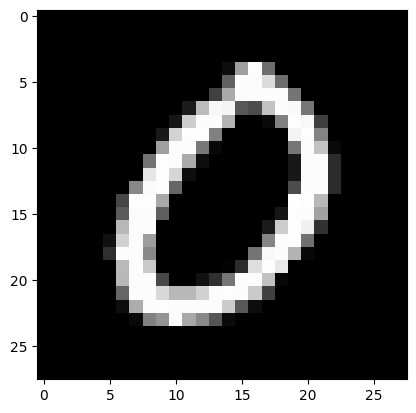

In [35]:
test_prediction(44, W1, b1, W2, b2)